### Combining GDP data with the jobs report

In [1]:
%matplotlib inline
import sys
sys.path.append('../src')

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

qtrs = {1: 1, 2: 1, 3: 1, 4: 2, 5:2, 6:2, 7:3, 8:3, 9:3, 10:4, 11:4, 12:4}

In [ ]:
aah = {}
epop = {}
cols = ['HRSACTT', 'LFS', 'BASICWGT', 'MONTH', 'PWSSWGT']
for year in range(1989, 2020):
    if year >= 1998:
        wgt = 'PWSSWGT'
    else:
        wgt = 'BASICWGT'
    df = pd.read_feather(cps_dir / f'cps{year}.ft', columns=cols)
    ah = (df.query('LFS == "Employed"')
            .groupby('MONTH').apply(lambda x: np.average(x.HRSACTT, weights=x.BASICWGT)))
    aah.update({f'{year}-{month}-01': value for month, value in list(zip(ah.index, ah.values))})
    
    ep = (df.query('LFS == "Employed"').groupby('MONTH')[wgt].sum() / 
          df.groupby('MONTH')[wgt].sum())
    epop.update({f'{year}-{month}-01': value for month, value in list(zip(ep.index, ep.values))})

In [ ]:
pd.Series(epop).to_csv('epop.csv', index_label='date', header=True)
pd.Series(aah).to_csv('aah.csv', index_label='date', header=True)

I can't seem to get X-13ARIMA-SEATS running on linux so I've used a virtual machine to convert epop.csv and aah.csv to epop_sa.csv and aah.csv using x13as with default settings.

In [2]:
epop_sa = (pd.read_csv('raw/epop_sa.csv', header=None, names=['date', 'value'], parse_dates=[0])
           .set_index('date').resample('QS').mean())

aah_sa = (pd.read_csv('raw/aah_sa.csv', header=None, names=['date', 'value'], parse_dates=[0])
           .set_index('date').resample('QS').mean())

In [ ]:
epop_sa.plot();

In [ ]:
aah_sa.plot();

In [3]:
gdp_code = ('T10106', ['A191RX'])
pop_code = ('T70100', ['B230RC'])

In [35]:
gdp_code = ('T10106', ['A191RX'])
pop_code = ('T70100', ['B230RC'])
gdp = nipa_df(retrieve_table(gdp_code[0])['Data'], gdp_code[1]).sort_index()
pop = nipa_df(retrieve_table(pop_code[0])['Data'], pop_code[1]).sort_index()

df = pd.DataFrame()
df['epop'] = epop_sa['value']
df['pop'] = pop['B230RC']
df['hours'] = aah_sa['value'] * 52
df['gdp'] = gdp['A191RX']
df['input'] = (df['pop'] * df['epop']) * df['hours']
df['gdpinp'] = df['gdp'] / df['input']


df['epop_c'] = ((df['pop'] * df['epop'].mean()) * df['hours']) * df['gdpinp']
df['pop_c'] = ((df['pop'].mean() * df['epop']) * df['hours']) * df['gdpinp']
df['hours_c'] = ((df['pop'] * df['epop']) * df['hours'].mean()) * df['gdpinp']

df_g = growth_rate(df)

df_g['pop_contr'] = df_g['gdp'] - df_g['pop_c']
df_g['epop_contr'] = df_g['gdp'] - df_g['epop_c']
df_g['hours_contr'] = df_g['gdp'] - df_g['hours_c']
df_g['prod'] = df_g['gdp'] - df_g['pop_contr'] - df_g['epop_contr'] - df_g['hours_contr']

In [58]:
result = df_g[['pop_contr', 'epop_contr', 'hours_contr', 'prod']].round(2)

In [60]:
result.to_csv('gdpjobs.csv', index_label='date')

In [43]:
df_g[['pop_contr', 'epop_contr', 'hours_contr', 'prod']].fillna('0').to_csv('gdpjobs.csv', index_label='date')

In [5]:
df = pd.DataFrame()
df['epop'] = epop_sa['value']

In [6]:
df['epop'] = epop_sa['value']

In [7]:
df['pop'] = pop['B230RC']

In [8]:
df['hours'] = aah_sa['value'] * 52

In [9]:
df['gdp'] = gdp['A191RX']

In [10]:
df['input'] = (df['pop'] * df['epop']) * df['hours']

In [11]:
df['gdpinp'] = df['gdp'] / df['input']

In [20]:
df['epop_c'] = ((df['pop'] * df['epop'].mean()) * df['hours']) * df['gdpinp']

In [21]:
df['pop_c'] = ((df['pop'].mean() * df['epop']) * df['hours']) * df['gdpinp']

In [22]:
df['hours_c'] = ((df['pop'] * df['epop']) * df['hours'].mean()) * df['gdpinp']

In [26]:
df_g = growth_rate(df)

In [32]:
df_g['epop_c']

date
1989-01-01         NaN
1989-04-01    3.462486
1989-07-01    2.885168
1989-10-01    0.770884
1990-01-01    4.997588
1990-04-01    2.896213
1990-07-01    2.492911
1990-10-01   -1.088250
1991-01-01    0.962365
1991-04-01    5.271913
1991-07-01    2.969664
1991-10-01    2.119167
1992-01-01    5.204767
1992-04-01    3.850858
1992-07-01    4.186364
1992-10-01    5.109717
1993-01-01    0.483271
1993-04-01    0.964048
1993-07-01    0.671837
1993-10-01    4.209559
1994-01-01    2.708130
1994-04-01    5.033303
1994-07-01    0.297136
1994-10-01    1.842336
1995-01-01    1.147113
1995-04-01    2.098810
1995-07-01    3.770459
1995-10-01    3.210838
1996-01-01    2.965462
1996-04-01    4.709948
                ...   
2012-04-01    1.324932
2012-07-01   -0.572013
2012-10-01   -0.125864
2013-01-01    4.699631
2013-04-01   -0.428418
2013-07-01    1.926386
2013-10-01    3.465894
2014-01-01   -2.543939
2014-04-01    4.242518
2014-07-01    4.409421
2014-10-01    0.496511
2015-01-01    2.684749
2015-0

In [34]:
df_g['gdp'] - df_g['pop_c']

date
1989-01-01         NaN
1989-04-01    0.926676
1989-07-01    1.128018
1989-10-01    1.092815
1990-01-01    0.939979
1990-04-01    1.253703
1990-07-01    1.407331
1990-10-01    1.352979
1991-01-01    1.202059
1991-04-01    1.306312
1991-07-01    1.441896
1991-10-01    1.377650
1992-01-01    1.225590
1992-04-01    1.383883
1992-07-01    1.522339
1992-10-01    1.430974
1993-01-01    1.179339
1993-04-01    1.234431
1993-07-01    1.381533
1993-10-01    1.338284
1994-01-01    1.110008
1994-04-01    1.230370
1994-07-01    1.312546
1994-10-01    1.272187
1995-01-01    1.081050
1995-04-01    1.141950
1995-07-01    1.323297
1995-10-01    1.252540
1996-01-01    1.020013
1996-04-01    1.207485
                ...   
2012-04-01    0.656894
2012-07-01    0.771325
2012-10-01    0.765404
2013-01-01    0.601330
2013-04-01    0.616650
2013-07-01    0.793896
2013-10-01    0.809624
2014-01-01    0.647943
2014-04-01    0.703573
2014-07-01    0.838560
2014-10-01    0.819143
2015-01-01    0.650726
2015-0

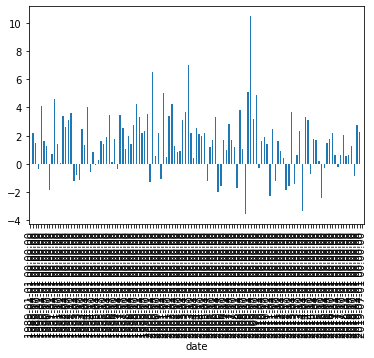

In [15]:
growth_rate(df['gdpinp']).plot(kind='bar')

In [ ]:
A191RX

In [ ]:
((((df.pct_change() + 1) ** 4) - 1) * 100)

In [ ]:
nipa_series_codes(retrieve_table('T70100'))

In [ ]:
pd.Series(d).to_csv('aah.csv', index_label='date')

In [ ]:
%matplotlib inline

In [ ]:
(pd.read_csv('raw/epop_sa.csv', header=None, names=['date', 'value'], parse_dates=[0]).set_index('date').plot())

In [ ]:
d = {}
cols = ['LFS', 'PWSSWGT', 'MONTH']
for year in range(1989, 2020):
    df = (pd.read_feather(cps_dir / f'cps{year}.ft', columns=cols)
            .query('LFS == "Employed"')
            .groupby('MONTH').HRSACTT.mean())
    d.update({f'{year}-{month}-01': value for month, value in list(zip(df.index, df.values))})